In [190]:
import csv
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from mlxtend.frequent_patterns import fpgrowth
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from multiprocessing import Pool
from tqdm import tqdm
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from textblob import TextBlob


### Загружаю уже запарсенный файл

In [191]:
df = pd.read_csv('/Users/arturarakelan/Downloads/twitter_data.csv')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,26,27,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1444206936782741504,1444206936782741504,1633160740000.0,2021-10-02 10:45:40,300.0,NaN,I think #Bitcoin is about to go on a run! #100k,en,"['bitcoin', '100k']",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1,1444206935130132482,1444206935130132482,1633160740000.0,2021-10-02 10:45:40,300.0,NaN,Looking for some crazy NFT shit? 🤪 #NFT #NFTs...,en,"['nft', 'nfts', 'nftfamily', 'nftcollectibles'...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,2,1444206933469274116,1444206933469274116,1633160739000.0,2021-10-02 10:45:39,300.0,NaN,FinanceMagnates: Bitcoin Transaction Volume In...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,3,1444206925898391552,1437427827767271426,1633160737000.0,2021-10-02 10:45:37,300.0,NaN,@babyswap_bsc @BinanceChain @binance @mini_kis...,en,"['minikishu', 'bsc', 'binance', 'bscgems', 'bs...",...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'babyswap_bsc', 'name': 'Baby...",NaN,NaN,NaN,NaN
4,4,1444206921607626759,1444206921607626759,1633160736000.0,2021-10-02 10:45:36,300.0,NaN,This is a great and powerful project which can...,en,"['airdrop', 'pancakeswap', 'btc', 'cryptocurre...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [192]:
%%time

from datetime import datetime
for i in range(len(df['date'])):
    
    if str(df['date'][i]) == 'nan':
        df['date'][i] = df['date'][i-1]
        df['date'][i] = pd.to_datetime(df['date'][i])
    elif (':' in df['date'][i]) == True:
        df['date'][i] = pd.to_datetime(df['date'][i])
    else:
        df['date'][i] = df['date'][i-1]
        df['date'][i] = pd.to_datetime(df['date'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellAp

CPU times: user 37min 39s, sys: 19.6 s, total: 37min 59s
Wall time: 1h 5min 6s


In [ ]:
# специальный токенизатор для твитов
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()

### Для проверки работоспособности и более быстрого расчета проверяется на выборке размером 10 000

In [ ]:
data_try = df[:10000]

In [ ]:
%%time

data_try['tokenized_word'] = 0

for i in range(len(data_try['tokenized_word'])):
    data_try['tokenized_word'][i] = TweetTokenizer(data_try['tweet'][i])

#df['tokenized_word'] = df['tweet'].apply(lambda x: TweetTokenizer(x.lower()))

In [ ]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [ ]:
%%time
data_try['new_tweets'] = None


for i in range(len(data_try)):
    data_try['new_tweets'][i] = words_only(data_try['tweet'][i])

In [ ]:

m = MorphAnalyzer()

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    if type(text) != float and text is not None:
        return [lemmatize_word(str(text[i])) for i in range(len(text))]

mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(tokens):
    #tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data_try['new_tweets']), total=len(df)))
    
data_try['lemmas'] = lemmas
data_try.sample(5)

In [ ]:
vec = CountVectorizer(ngram_range=(2, 2)) # строим BoW для слов
bow = vec.fit_transform(data_try['lemmas']) 

In [ ]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data_try['lemmas']) 

In [ ]:
%%time

X = tfidf.todense()
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca)

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(x = X_pca[:,0], y = X_pca[:,1])

In [ ]:
from sklearn.manifold import TSNE

X = tfidf.todense()
X_TSNE = TSNE(n_components=2).fit_transform(X)

print("X_TSNE now has just 2 columns:")
print(X_TSNE)

In [ ]:
plt.scatter(x = X_TSNE[:,0], y = X_TSNE[:,1])

## Далее идет аналогичный код только для большего размера выборки. Но  в какой-то момент компьютер перестал считать.

In [ ]:
#%%time

#df['tokenized_word'] = 0

#for i in range(len(df['tokenized_word'])):
    #df['tokenized_word'][i] = TweetTokenizer(df['tweet'][i])

#df['tokenized_word'] = df['tweet'].apply(lambda x: TweetTokenizer(x.lower()))

In [ ]:
#%%time

#df['new_tweets'] = None
#for i in range(len(df['new_tweets'])):
    #df['new_tweets'][i] = df['tweet'].findall('[-+][0-9.]+|\S')

In [193]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [194]:
%%time
df['new_tweets'] = None
for i in range(len(df)):
    df['new_tweets'][i] = words_only(df['tweet'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 29min 55s, sys: 15.2 s, total: 30min 10s
Wall time: 30min 1s


In [195]:
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

In [196]:
m = MorphAnalyzer()

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    if type(text) != float and text is not None:
        return [lemmatize_word(str(text[i])) for i in range(len(text))]

mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(tokens):
    #tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [197]:
from multiprocessing import Pool
from tqdm import tqdm

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['new_tweets']), total=len(df)))
    
df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 542767/542767 [01:05<00:00, 8322.90it/s] 


,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,new_tweets,lemmas
376639,NaN,NaN,NaN,NaN,2021-09-28 22:04:02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],
321449,207688,1443122113745936387,1443122113745936387,1632902098000.0,2021-09-29 10:54:58,300.0,NaN,¿Alguien sabe porque #Binance ha deshabilitado...,es,"['binance', 'bitcoin']",...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[alguien, sabe, porque, binance, ha, deshabili...",alguien sabe porque binance deshabilitado trad...
341987,228226,1442986048900907013,1442986048900907013,1632869658000.0,2021-09-29 01:54:18,300.0,NaN,#tumblr #twitter #facebook #instagram #dogecoi...,en,"['tumblr', 'twitter', 'facebook', 'instagram',...",...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[tumblr, twitter, facebook, instagram, dogecoi...",tumblr twitter facebook instagram dogecoin soc...
381639,241654,1442913011367247872,1442913011367247872,1632852244000.0,2021-09-28 21:04:04,300.0,NaN,Twitter ahora permite propinas en Bitcoin y Al...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[twitter, ahora, permite, propinas, en, bitcoi...",twitter ahora permite propinas bitcoin altcoin...
383795,241654,1442913011367247872,1442913011367247872,1632852244000.0,2021-09-28 21:04:04,300.0,NaN,Twitter ahora permite propinas en Bitcoin y Al...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[twitter, ahora, permite, propinas, en, bitcoi...",twitter ahora permite propinas bitcoin altcoin...


In [198]:
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams

In [199]:
vec = CountVectorizer(ngram_range=(2, 2)) # строим BoW для слов
bow = vec.fit_transform(df['lemmas']) 

In [200]:
list(vec.vocabulary_.items())[:10]

[('think bitcoin', 1263534),
 ('looking crazy', 810324),
 ('crazy shit', 275561),
 ('shit nfts', 1159407),
 ('nfts nftfamily', 918213),
 ('nftfamily nftcollectibles', 917165),
 ('nftcollectibles nftcollection', 916506),
 ('nftcollection nftopensea', 916569),
 ('nftopensea nftcommunity', 917578),
 ('nftcommunity bayc', 916852)]

In [201]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['lemmas']) 

In [202]:
def getSubjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity

def getPolarity(twt):
    return TextBlob(twt).sentiment.polarity



In [203]:
%%time

df['Subjectivity'] = df['lemmas'].apply(getSubjectivity)
df['Polarity'] = df['lemmas'].apply(getPolarity)

CPU times: user 2min 59s, sys: 1.8 s, total: 3min 1s
Wall time: 3min 2s


In [204]:
df.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,new_tweets,lemmas,Subjectivity,Polarity
0,0,1444206936782741504,1444206936782741504,1633160740000.0,2021-10-02 10:45:40,300.0,NaN,I think #Bitcoin is about to go on a run! #100k,en,"['bitcoin', '100k']",...,NaN,[],NaN,NaN,NaN,NaN,"[i, think, bitcoin, is, about, to, go, on, a, ...",think bitcoin,0.000,0.000
1,1,1444206935130132482,1444206935130132482,1633160740000.0,2021-10-02 10:45:40,300.0,NaN,Looking for some crazy NFT shit? 🤪 #NFT #NFTs...,en,"['nft', 'nfts', 'nftfamily', 'nftcollectibles'...",...,NaN,[],NaN,NaN,NaN,NaN,"[looking, for, some, crazy, nft, shit, nft, nf...",looking crazy shit nfts nftfamily nftcollectib...,0.850,-0.400
2,2,1444206933469274116,1444206933469274116,1633160739000.0,2021-10-02 10:45:39,300.0,NaN,FinanceMagnates: Bitcoin Transaction Volume In...,en,[],...,NaN,[],NaN,NaN,NaN,NaN,"[financemagnates, bitcoin, transaction, volume...",financemagnates bitcoin transaction volume inc...,0.750,-0.125
3,3,1444206925898391552,1437427827767271426,1633160737000.0,2021-10-02 10:45:37,300.0,NaN,@babyswap_bsc @BinanceChain @binance @mini_kis...,en,"['minikishu', 'bsc', 'binance', 'bscgems', 'bs...",...,NaN,"[{'screen_name': 'babyswap_bsc', 'name': 'Baby...",NaN,NaN,NaN,NaN,"[babyswap_bsc, binancechain, binance, mini_kis...",babyswap_bsc binancechain binance mini_kishu m...,0.000,0.000
4,4,1444206921607626759,1444206921607626759,1633160736000.0,2021-10-02 10:45:36,300.0,NaN,This is a great and powerful project which can...,en,"['airdrop', 'pancakeswap', 'btc', 'cryptocurre...",...,NaN,[],NaN,NaN,NaN,NaN,"[this, is, a, great, and, powerful, project, w...",great powerful project change things make brig...,0.735,0.520


In [205]:
df['date'] = df['date'].values.astype('<M8[m]')

In [206]:
grouped_data = df.groupby('date').agg({'Subjectivity': 'mean', 'Polarity':'mean', 'lemmas':'count'})
grouped_data = grouped_data.reset_index()
grouped_data.columns = ['date', 'Subjectivity', 'Polarity', 'count']
grouped_data.head()

,date,Subjectivity,Polarity,count
0,2021-09-27 23:39:00,0.254327,0.090616,27
1,2021-09-27 23:40:00,0.204215,0.076981,50
2,2021-09-27 23:41:00,0.303522,0.104409,49
3,2021-09-27 23:42:00,0.185342,0.072069,39
4,2021-09-27 23:43:00,0.229131,0.107638,43


In [354]:
data_copy = grouped_data.copy()

In [353]:
import yfinance as yf

btc = yf.Ticker("BTC-USD")

btc_price = btc.history(
    start = '2021-09-28',
    end = '2021-10-03',
    interval = '1m').reset_index()

btc_price['Datetime'] = btc_price['Datetime'].dt.tz_localize(None)
btc_price = btc_price[['Datetime', 'Close']]
btc_price['Close'] = btc_price['Close'].pct_change()

In [ ]:
btc_price[98:]

In [355]:
data_fin = data_copy.merge(btc_price,how='inner', left_on='date', right_on='Datetime')
data_fin.head()
#data_copy.merge(btc_price,how='inner', left_on='date', right_on='Datetime')

,date,Subjectivity,Polarity,count,Datetime,Close
0,2021-09-27 23:39:00,0.254327,0.090616,27,2021-09-27 23:39:00,-0.000154
1,2021-09-27 23:40:00,0.204215,0.076981,50,2021-09-27 23:40:00,-0.001015
2,2021-09-27 23:41:00,0.303522,0.104409,49,2021-09-27 23:41:00,0.000046
3,2021-09-27 23:42:00,0.185342,0.072069,39,2021-09-27 23:42:00,-0.000205
4,2021-09-27 23:43:00,0.229131,0.107638,43,2021-09-27 23:43:00,0.000174


In [356]:
X = data_fin[['Subjectivity', 'Polarity', 'count']]
y = data_fin['Close']

In [357]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [415]:
s = 100
m = len(data_fin) - s


X_train = data_fin[['Polarity', 'Subjectivity','count']][:m-1]
y_train = data_fin['Close'][:m-1]

X_test = data_fin[['Polarity','Subjectivity', 'count']][m:]
y_test = data_fin['Close'][m:]

In [416]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [417]:
expected_y  = y_test
predicted_y = model.predict(X_test)

In [418]:
print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_error(expected_y, predicted_y))

-0.09938014296454001
2.0573978192975592e-07


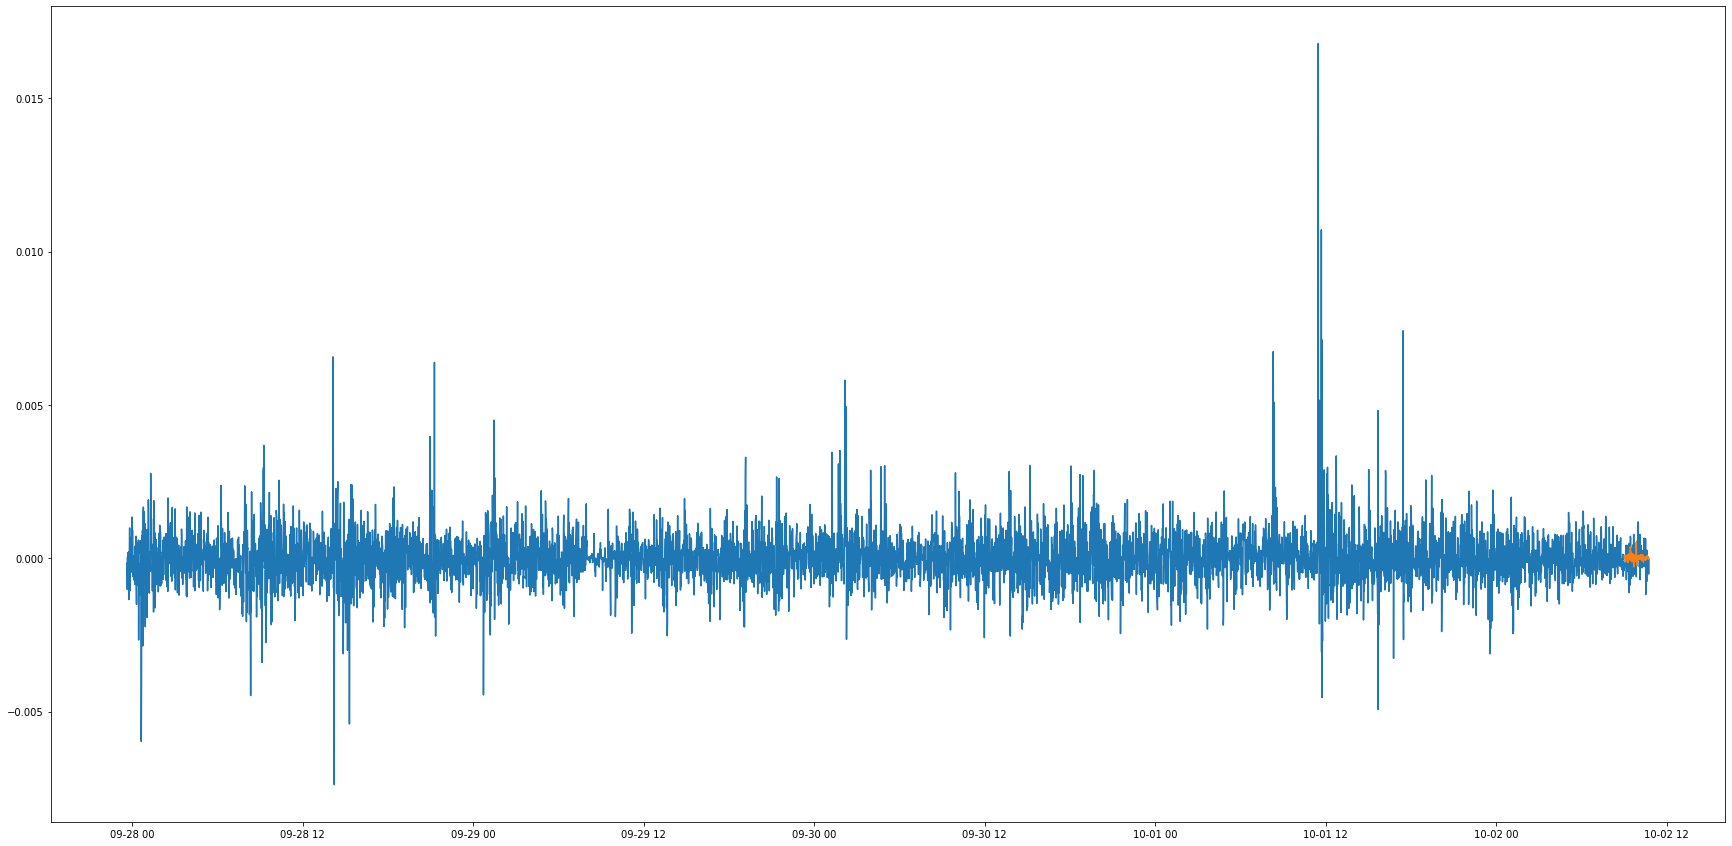

In [419]:
import matplotlib.pyplot as plt

n = len(data_fin) - len(expected_y)

plt.figure(figsize=(30,15))

plt.plot(data_fin['date'], y)
plt.plot(data_fin['date'][n:], predicted_y)
plt.show()

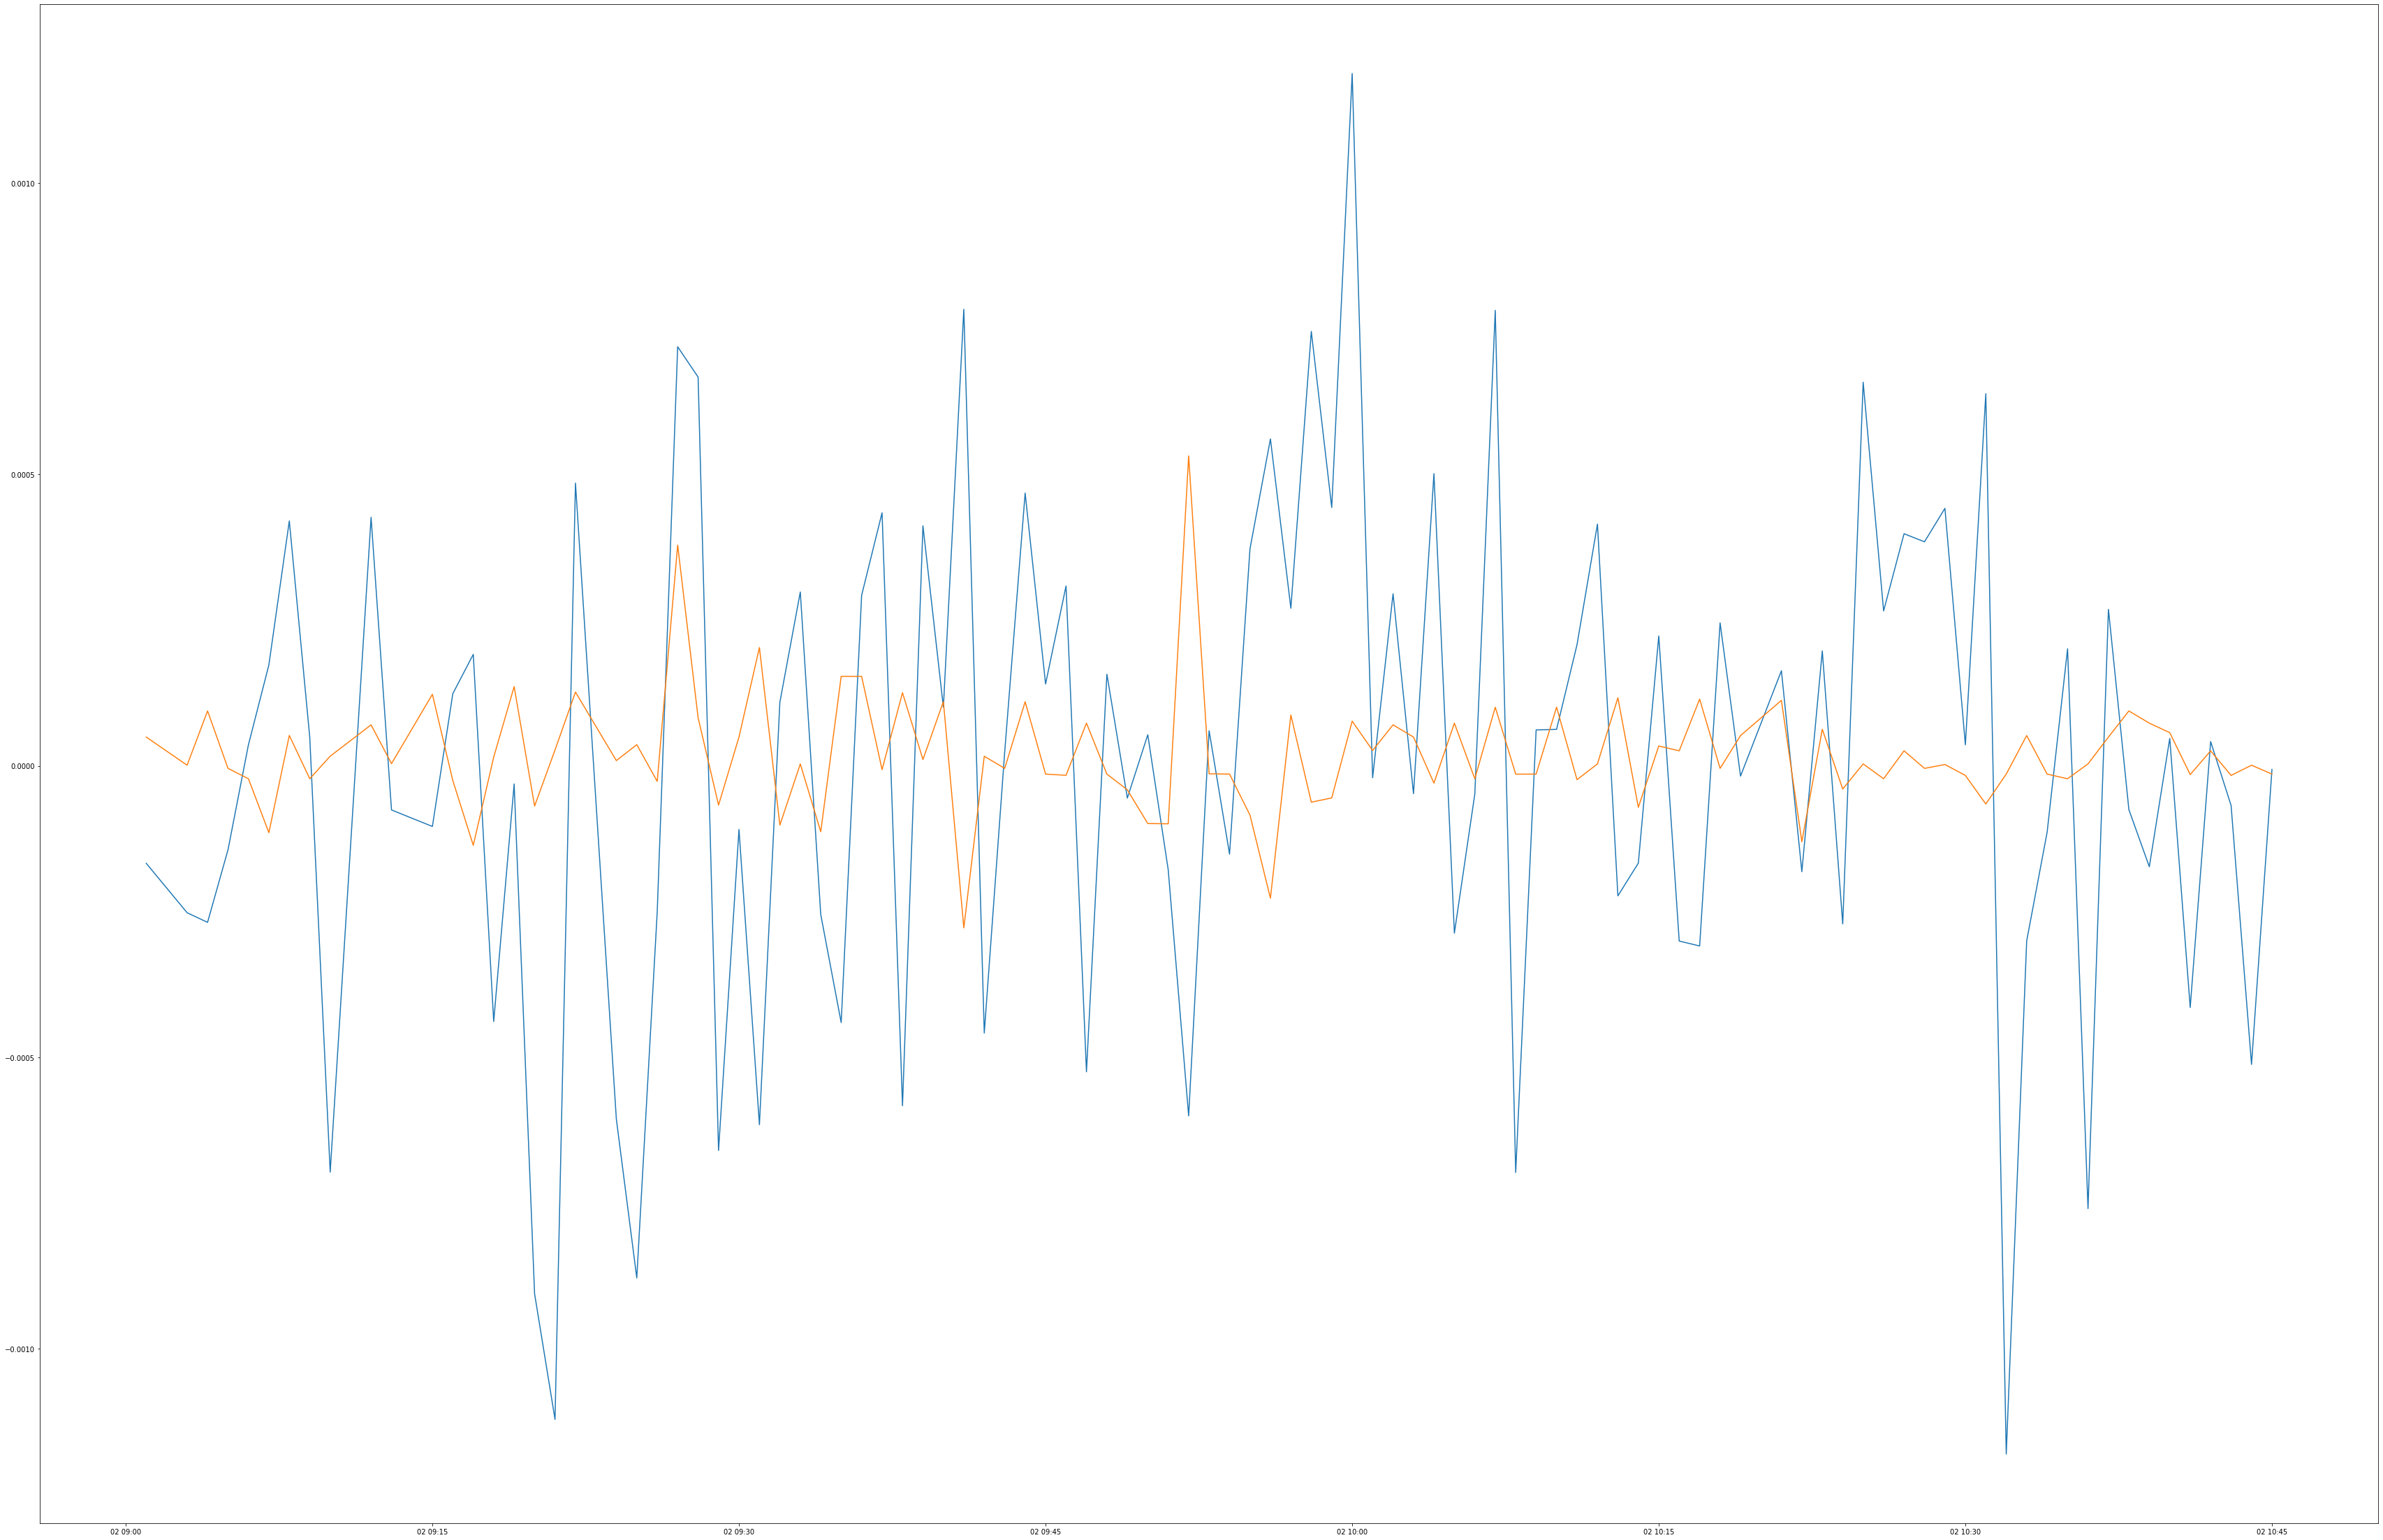

In [422]:
n = len(data_fin) - len(expected_y)

plt.figure(figsize=(60,40))

plt.plot(data_fin['date'][n:], expected_y)
plt.plot(data_fin['date'][n:], predicted_y)
plt.show()

In [405]:
predicts = []

for i in range(1,s):
    end = len(data_fin) - (s - i)-1
    start = i
    X_train_i = data_fin[['Subjectivity', 'Polarity', 'count']][start:end]
    y_train_i = data_fin['Close'][start:end]
    model_i = xgb.XGBRegressor()
    model_i.fit(X_train_i, y_train_i)
    #print(X_train_i)
    #print(y_train_i)
    a = len(data_fin) - (s - i)
    X_test_i = data_fin[['Subjectivity', 'Polarity', 'count']][a:a+1]
    #print(X_test_i)
    predicted_y = model.predict(X_test_i)
    predicts.append(predicted_y)
    

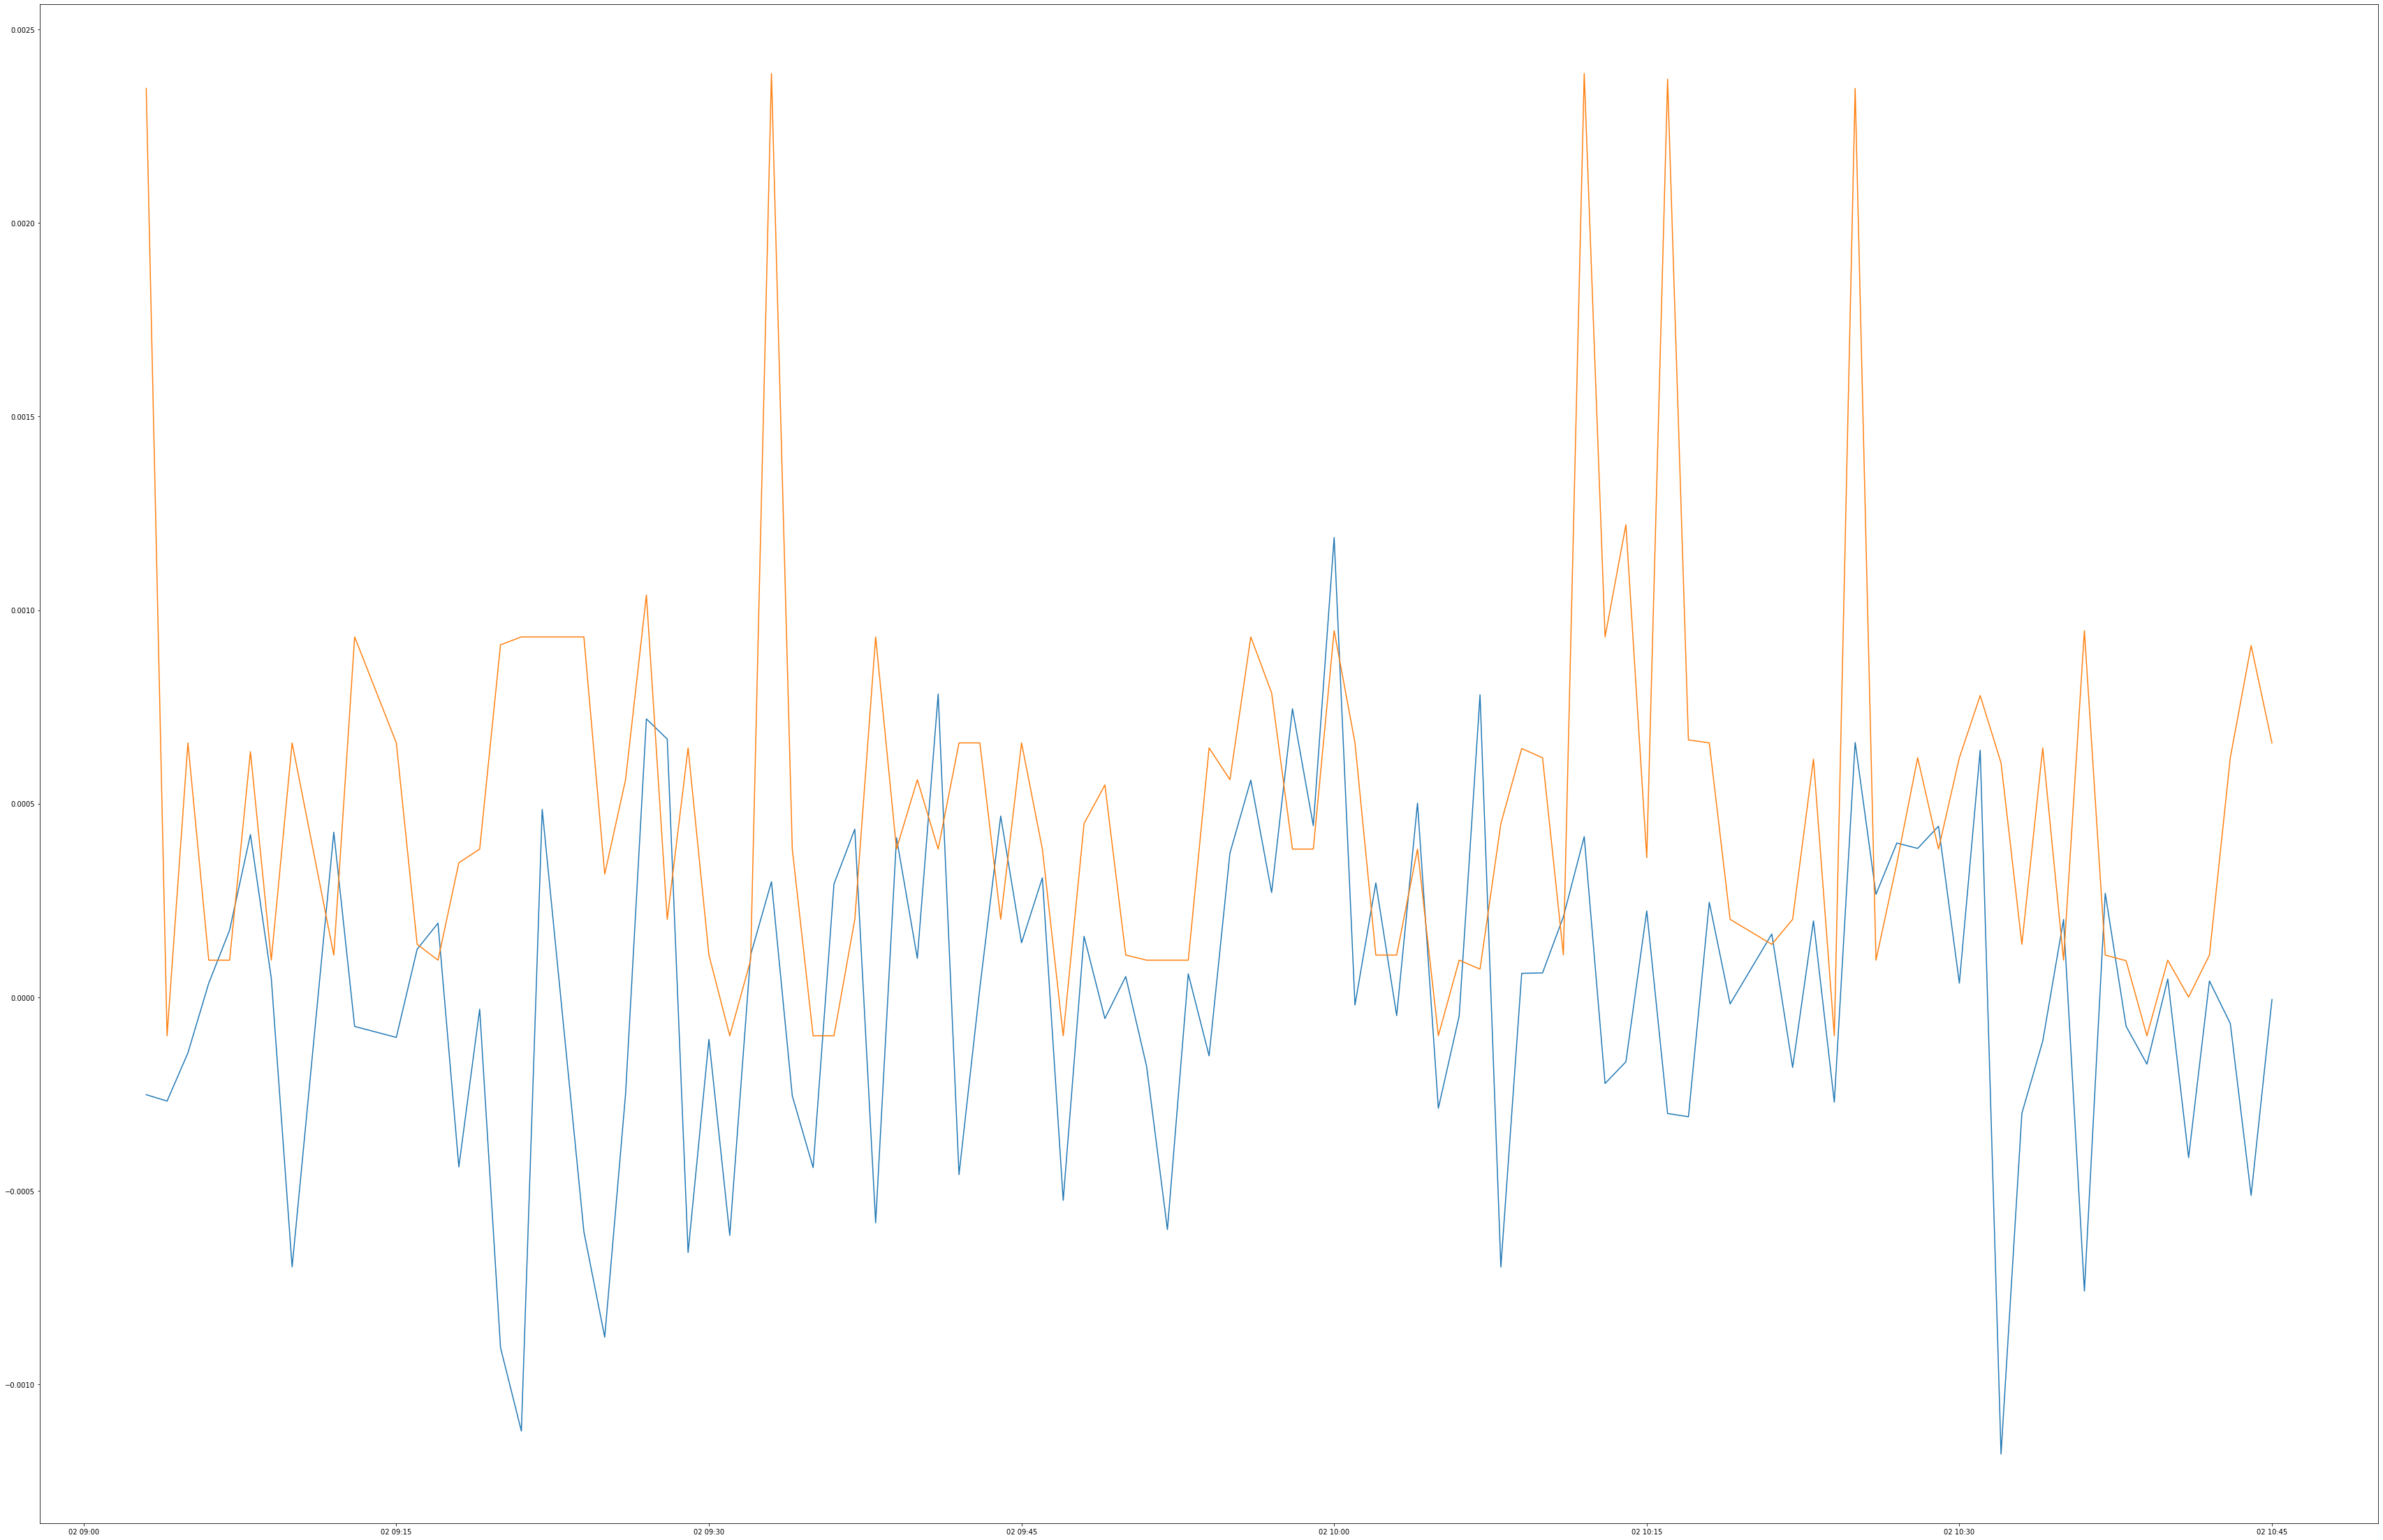

In [412]:
aaa = len(data_fin) - s + 1 

plt.figure(figsize=(60,40))

plt.plot(data_fin['date'][aaa:], data_fin['Close'][aaa:])
plt.plot(data_fin['date'][aaa:], predicts)
plt.show()

In [424]:
print(metrics.r2_score(data_fin['Close'][aaa:], predicts))
print(metrics.mean_squared_error(data_fin['Close'][aaa:], predicts))

-2.7851962657568388
7.144049908159736e-07


## Далее идет PCA, который не запускается (kernel перезапускается) 

In [ ]:
%%time

X = tfidf.todense()
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca)